## Library

In [89]:
import pandas as pd
import numpy as np
import re
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
import matplotlib.dates as mdates
from datetime import datetime
from numpyro.contrib.control_flow import scan
import matplotlib as mpl
import warnings
warnings.simplefilter('ignore')
import seaborn as sns

numpyro.enable_x64()    

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# --------------------------------------------------------
# helper: draw one decomposition in an existing Axes
# --------------------------------------------------------
def plot_decomposition_ax(ax, date, original, trend, cycle, title, loc="upper left"):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # level & trend  ------------------------
    ax.plot(date, original, label="Original", color=colors[0])
    ax.plot(date, trend,    label="Trend",    color=colors[1])
    ax.set_xlabel("Year")
    ax.set_ylabel("level / trend")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)

    # cycle (twin axis) ---------------------
    ax2 = ax.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2])
    ax2.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax2.set_ylabel("Cycle")
    ax2.tick_params(axis="y", colors=colors[2])

    # legend (combine both axes) ------------
    lines  = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=loc, frameon=False)


In [90]:
# cpi data
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])

# Markup data
data_markup = pd.read_excel("data/nekarda_ramey_markups.xlsx")
data_markup['DATE'] = pd.to_datetime(data_markup['qdate'], format='%Y-%m-%d')
data_markup['markup'] = data_markup['mu_bus']
data_markup = data_markup[['DATE', 'markup']].dropna()

# output gap data
data_output = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_output['output_BN'] = data_output['GDPC1_transformed_series']
data_output['output_gap_BN'] = data_output["cycle"]
data_output['output'] = np.log(data_output["GDPC1_original_series"] * 0.01)
data_output['DATE'] = data_output["date"]
data_output["output_trend_BN"] = data_output["output_BN"] - data_output["output_gap_BN"]
data_output = data_output[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]].dropna()
data_output['DATE'] = pd.to_datetime(data_output['DATE'])


# inflation expectation data
data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

# HHI
data_N_annual = pd.read_excel("data/WITS-Country-Timeseries.xlsx")
data_N_annual["HHI"] = data_N_annual["Unnamed: 1"]
data_N_annual['year'] = pd.to_datetime(data_N_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_annual = data_N_annual.set_index('year')
data_N = data_N_annual.resample('QS').asfreq()
data_N['HHI'] = data_N['HHI'].interpolate(method='linear')
data_N = data_N.reset_index()
data_N['DATE'] = pd.to_datetime(data_N['year'])
data_N = data_N[["DATE", "HHI"]]
data_N["N"] = np.log(1/data_N["HHI"]) 
data_N.to_csv("data/N_HHI.csv", index=False)


data_N_hat_annual = pd.read_csv("data/BN_filter_user_inputted_series_results_HHI.csv")
data_N_hat_annual["year"] = (
    pd.to_datetime(data_N_hat_annual["date"])   # ①
      .dt.year                                  # ②
)
data_N_hat_annual['DATE'] = pd.to_datetime(data_N_hat_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_hat_annual = data_N_hat_annual.set_index('DATE')
data_N_hat = data_N_hat_annual.resample('QS').asfreq()
data_N_hat = data_N_hat.reset_index()
data_N_hat['N_hat_BN'] = data_N_hat['cycle'].interpolate(method='linear')
data_N_hat["original_series"] = data_N_hat['original_series'].interpolate(method='linear')
data_N_hat["N_trend_BN"] = data_N_hat['trend'].interpolate(method='linear')
data_N_hat = data_N_hat[["DATE", "N_hat_BN", "N_trend_BN"]]

# # data_N
# data_Nb = pd.read_csv("data/BDSTIMESERIES.BDSGEO-2025-02-26T120133.csv")
# data_Nb = data_Nb[["Year (time)", "Number of firms (FIRM)"]]
# data_Nb['year'] = pd.to_datetime(data_Nb['Year (time)'], format='%Y') + pd.offsets.YearBegin(0)
# data_Nb = data_Nb.set_index('year')
# data_Nb = data_Nb[["Year (time)", "Number of firms (FIRM)"]].copy()
# data_Nb["N"] = pd.to_numeric(data_Nb["Number of firms (FIRM)"].str.replace(",", ""), errors="coerce")
# data_Nb = data_Nb.resample('QS').asfreq()
# data_Nb['Nb'] = np.log(data_Nb['N'].interpolate(method='linear'))
# data_Nb = data_Nb.reset_index()
# data_Nb['DATE'] = pd.to_datetime(data_Nb['year'])
# data_Nb = data_Nb[["DATE", "Nb"]]

data_Nb = pd.read_csv("data/BLS-bd-BDS0000000000000000120007LQ5.csv")
data_Nb["N_end"] = data_Nb["National – Establishment Births – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120007LQ5)"]
data_Nb["Nb"] = data_Nb["N_end"] * 1000
data_Nb['q'] = data_Nb["period"]
data_Nb["q"] = data_Nb["q"].str.replace(" ", "")
data_Nb["DATE"] = data_Nb["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nb = data_Nb[["DATE", "Nb"]]
data_Nd = pd.read_csv("data/BLS-bd-BDS0000000000000000120008LQ5.csv")
data_Nd["N_end"] = data_Nd["National – Establishment Deaths – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120008LQ5)"]
data_Nd["Nd"] = data_Nd["N_end"] * 1000
data_Nd['q'] = data_Nd["period"]
data_Nd["q"] = data_Nd["q"].str.replace(" ", "")
data_Nd["DATE"] = data_Nd["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nd = data_Nd[["DATE", "Nd"]]
data_Nb = pd.merge(data_Nb, data_Nd, on = "DATE")
data_Nb = data_Nb.dropna()
data_Nb["Nchange"] = data_Nb["Nb"] - data_Nb["Nd"]
data_Nb = data_Nb[data_Nb["DATE"] >= "1993-04-01"]
initial_value = 5387024
data_Nb["Nb"] = initial_value + data_Nb["Nchange"].shift(fill_value=0).cumsum()
data_Nb["Nb"] = np.log(data_Nb["Nb"])
data_Nb = data_Nb[["DATE", "Nb"]]

# Merge all dataframes
data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_output, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")
data = pd.merge(data, data_markup, on="DATE", how="outer")
data = pd.merge(data, data_Nb, on="DATE", how="outer")
data = pd.merge(data, data_N_hat, on="DATE", how="outer")
data["pi_prev"] = data["pi"].shift(1)
data["Epi"] = data["Epi"].shift(-1)
data["output_gap_BN"] = data["output_gap_BN"].shift(-1)
data["markup"] = data["markup"].shift(-1)
data["N"] = data["N"].shift(-1)
data["output_gap_prev"] = data["output_gap_BN"]
data["markup_prev"] = data["markup"]
data = data.dropna()


# for MCMC
pi = jnp.array(data['pi'],dtype=jnp.float64)
pi_prev = jnp.array(data['pi_prev'],dtype=jnp.float64)
pi_expect = jnp.array(data['Epi'],dtype=jnp.float64)
N = jnp.array(data['N'],dtype=jnp.float64)
# Nb = jnp.array(data['Nb'],dtype=jnp.float64)
Y = jnp.array(data['output'],dtype=jnp.float64)
x_markup = jnp.array(1/data['markup'],dtype=jnp.float64)
x_output_gap = jnp.array(data['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev = jnp.array(data['output_gap_prev'],dtype=jnp.float64)
x_markup_prev = jnp.array(1/data['markup_prev'],dtype=jnp.float64)

x = x_markup
x_prev = x_markup_prev
# N_hat = jnp.array(data["N_hat"], dtype=jnp.float64)


---
---
# Estimation strategies (3 patterns)
### NKPC under CES
$s(z_t) = \gamma_{CES}(z_t)^{1−\theta}$

$\theta$ denotes the constant price elasticity, and $\zeta(z) = \theta$ and $\rho(z) = 1$:
$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t-1}+\underset{\kappa}{\underbrace{\frac{\theta-1}{\chi}}}x_{t}+v_{t}
$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

Estimated parameters are $\alpha$, $\theta$, $\chi$ and $\sigma_{v}$.

$\chi$: scales the size of the cost

$\theta$: the constant price elasticity,


### NKPC under HSA

$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t-1}+\underset{\kappa}{\underbrace{\frac{\zeta(z)-1}{\chi}}}x_{t}-\underset{\theta}{\underbrace{\frac{1-\rho(z)}{\rho(z)\chi}}}\hat{N}_{t}+v_{t},
$$
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
where
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\epsilon_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\eta_{t},
$$

$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad \eta_t \sim \mathcal{N}(0, \sigma_{v}^2)
$$

Estimated parameters are $\alpha$, $\kappa$, $\theta$, $\rho_1$, $\rho_2$, $n$, $\psi$,  $\sigma_{v}$, $\sigma_{\epsilon}$, and $\sigma_{\eta}$.

$\zeta(z) = 1-\frac{s′(z)z}{s(z)}$ : the price elasticity function $\zeta(z) > 1$

$\rho(z)=[1-\frac{dln(\frac{\zeta(z)}{\zeta(z)-1})}{dln(z)}]^{-1}$   : the pass-through rate function, $1 >\rho(z) > 0$

### Shift in the slope
$$
\pi_{t}=\alpha\pi_{t-1}+(1-\alpha)\mathbb{E}_{t}\pi_{t-1}+\underset{\kappa}{\underbrace{\frac{\zeta(z)-1}{\chi}}}x_{t}-\underset{\theta}{\underbrace{\frac{1-\rho(z)}{\rho(z)\chi}}}\hat{N}_{t}+v_{t},
$$
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
where
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\epsilon_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\eta_{t},
$$

$$
\kappa_{t}= \psi \kappa_{t-1} - \delta \hat{N}_{t}
$$

$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$

Estimated parameters are $\alpha$, $\kappa$, $\theta$, $\rho_1$, $\rho_2$, $n$, $\delta$, $\psi$,  $\sigma_{v}$, $\sigma_{u}$, $\sigma_{\epsilon}$, $\sigma_{\eta}$.



## Restrictions on the estimation strategies
$0<\alpha<1$,

$0<\kappa$,  

$0<\theta$

$0<\psi$ 

$\rho_1$ and $\rho_2$ must satisfy 

$\rho_2 - \rho_1 < 1$

$\rho_2 + \rho_1 < 1$

$|\rho_2| < 1$

To satisfy $\rho$ restrictions, 
we set prior for $\rho_1$ as a uniform distribution over $(0,2)$ and prior for $\rho_2$ as a uniform distribution over $(-1,0)$.

In addition, we don't adopt pairs of $\rho_1$ and $\rho_2$ which is not satisfying $\rho$ restrictions.



Another way:
we first sample the damping factor ($-1<r<1$) and frequency of the cycle($0<p<1$) and then calculate $\rho_1 = 2rcos(\pi p)$ and $\rho_2 = -r^2$.

$z^2 - \rho_1 z - \rho_2=0$

$z_{1,2} = r e^{\pm i \pi p}$ 

Therefore, 

$\rho_1 = z_1 + z_2 = r e^{i \pi p} + r e^{-i \pi p}= 2 r \cos(\pi p)$

$\rho_2 = -z_1 z_2 = - r^2$

In [91]:
warmup= 1000
samples=4000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

def set_prior_distributions():
    priors = {
        # NKPC params
        "alpha"      : dist.Beta(2, 5),
        "kappa"      : dist.Beta(2, 5),
        "kappa_init" : dist.Beta(2, 5),
        "theta"      : dist.Beta(2, 5),
        "delta"      : dist.Beta(2, 5),
        "psi"        : dist.Beta(2, 5),
        "n"          : dist.Beta(2, 5), 
        # Sigma
        "sigma_u"    : dist.LogNormal(0, 1),  
        "sigma_eps"  : dist.LogNormal(0, 1),  
        "sigma_v"    : dist.LogNormal(0, 1),  
        "sigma_mu"   : dist.LogNormal(0, 1),  
        "sigma_e"    : dist.LogNormal(0, 1),  
        "sigma_eta"  : dist.LogNormal(0, 1),  
    }
    return priors

In [92]:
def model_0(pi, pi_prev, pi_expect, x):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha", priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_v = numpyro.sample("sigma_v", priors["sigma_v"])
    # model
    pi_pred = alpha * pi_prev + (1-alpha) * pi_expect + kappa * x
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi)

def model_1(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    # rho_1 = numpyro.sample("rho_1", dist.Uniform(0,2))
    # rho_2 = numpyro.sample("rho_2", dist.Uniform(-1,0))
    r = numpyro.sample("r", dist.Uniform(-1,1))  # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, .05))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        t = carry[3]
        # state equation
        # trend 
        log_Nbar_t = numpyro.sample("log_Nbar", dist.Normal(jnp.log(n + Nbar_prev), sigma_eps))
        Nbar_t = numpyro.deterministic("Nbar", jnp.exp(log_Nbar_t))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1 , t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, t], timesteps)

# NKPC under CES =================================================
print("NKPC under CES")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x_markup)
idata_0_m = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
diverging  = idata_0_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param
# NKPC under HSA : no shift in slope ==============================
print("NKPC under HSA : no shift in slope")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, N = N, l=len(pi))
idata_1_m = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_1_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_1_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_1_m = N_bar_mean_1_m - 1.97 * N_bar_std_1_m
N_bar_upper_1_m = N_bar_mean_1_m + 1.97 * N_bar_std_1_m
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_1_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_1_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_1_m = N_hat_mean_1_m - 1.97 * N_hat_std_1_m
N_hat_upper_1_m = N_hat_mean_1_m + 1.97 * N_hat_std_1_m
diverging  = idata_1_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# ====================================================================
dict_idata = {
    'NKPC under CES':idata_0_m,
    'HSA NKPC no-shift / markup':idata_1_m
    }
params = [
    "alpha", "kappa", "theta", "rho_1","rho_2", "phi", 'delta' ,  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

NKPC under CES


sample: 100%|██████████| 5000/5000 [00:02<00:00, 2342.15it/s, 15 steps of size 1.94e-01. acc. prob=0.99]


model 0: divergence ratio = 0.0000%
NKPC under HSA : no shift in slope


sample: 100%|██████████| 5000/5000 [03:38<00:00, 22.87it/s, 127 steps of size 2.38e-02. acc. prob=0.94] 


Model 1 : divergence ratio = 0.0000%


,model,alpha,kappa,theta,rho_1,rho_2,phi,delta,n
0,NKPC under CES,0.155,0.079,-,-,-,-,-,-
1,HSA NKPC no-shift / markup,0.157,0.078,0.269,1.792,-0.891,-,-,0.004


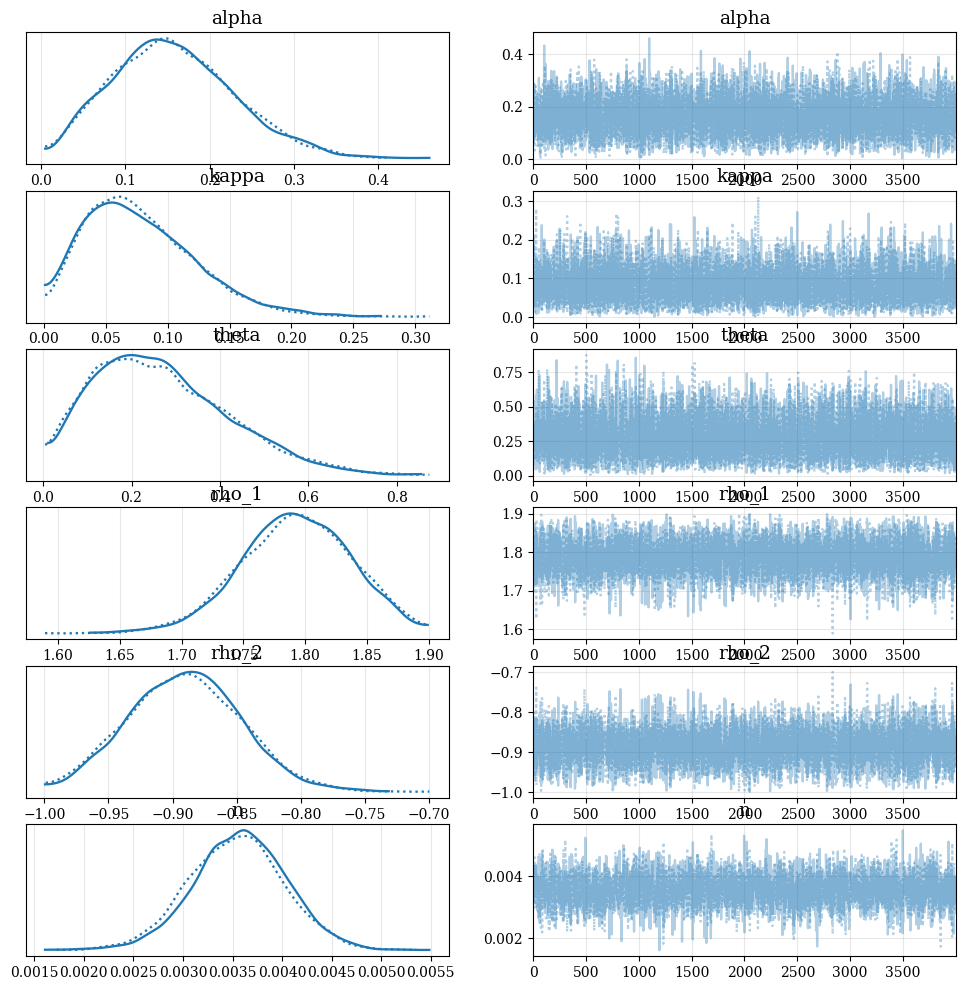

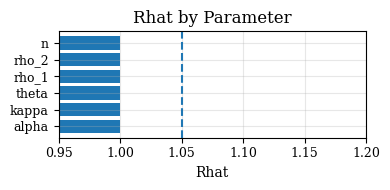

In [93]:
az.plot_trace(idata_1_m, var_names=["alpha", "kappa", "theta", "rho_1","rho_2" , "n"])
# az.plot_autocorr(idata_1_m, var_names=["alpha", "kappa", "theta", "rho_1","rho_2" , "n"])
summary = az.summary(idata_1_m,var_names=["alpha", "kappa", "theta", "rho_1","rho_2" , "n"],round_to=2)
rhat = summary['r_hat'].sort_values(ascending=False)
# 3) Plot
plt.figure(figsize=(4, 2))
plt.barh(rhat.index, rhat.values)
plt.axvline(1.05, linestyle='--')        # threshold line
plt.xlabel('Rhat')                         
plt.title('Rhat by Parameter')             
plt.xlim(0.95, 1.2)
plt.tight_layout()
plt.show()


In [94]:
def model_2(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    # rho_1 = numpyro.sample("rho_1", dist.Uniform(0,2))
    # rho_2 = numpyro.sample("rho_2", dist.Uniform(-1,0))
    r = numpyro.sample("r", dist.Uniform(-1,1))  # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    delta = numpyro.sample("delta", priors["delta"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])         
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))  # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, 0.1))  # Nhat init
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # N 
        m_t = n + Nbar_prev                     
        m_t_pos = jnp.clip(m_t, 1e-8)           
        mu_t = jnp.log(m_t_pos) - 0.5 * sigma_eps**2
        Nbar_t = numpyro.sample("Nbar", dist.LogNormal(mu_t, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # kappa
        kappa_t = numpyro.deterministic("kappa", delta * (1/Nbar_t))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_prev, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa_0 , t], timesteps)

# model 2
print("NKPC under HSA: shift in slope")
kernel = NUTS(model_2, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, x=x, N=N, l=len(pi))
idata_2_m = az.from_numpyro(mcmc)

# Results
posterior_samples = mcmc.get_samples()
N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_2_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_2_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_2_m = N_bar_mean_2_m - 1.97 * N_bar_std_2_m
N_bar_upper_2_m = N_bar_mean_2_m + 1.97 * N_bar_std_2_m
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_2_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_2_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_2_m = N_hat_mean_2_m - 1.97 * N_hat_std_2_m
N_hat_upper_2_m = N_hat_mean_2_m + 1.97 * N_hat_std_2_m
kappa_samples = posterior_samples["kappa"]
kappa_mean_2_m = np.mean(kappa_samples, axis=0) 
kappa_std_2_m = np.std(kappa_samples, axis=0)  
kappa_lower_2_m = kappa_mean_2_m - 1.97 * kappa_std_2_m
kappa_upper_2_m = kappa_mean_2_m + 1.97 * kappa_std_2_m

diverging  = idata_2_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'NKPC under HSA: shift':idata_2_m
    }
params = [
    "alpha", "kappa", "theta", "rho_1","rho_2", "delta", "psi" ,  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

NKPC under HSA: shift in slope


sample:  29%|██▉       | 1442/5000 [04:22<10:47,  5.50it/s, 1023 steps of size 9.14e-03. acc. prob=0.99]


KeyboardInterrupt: 

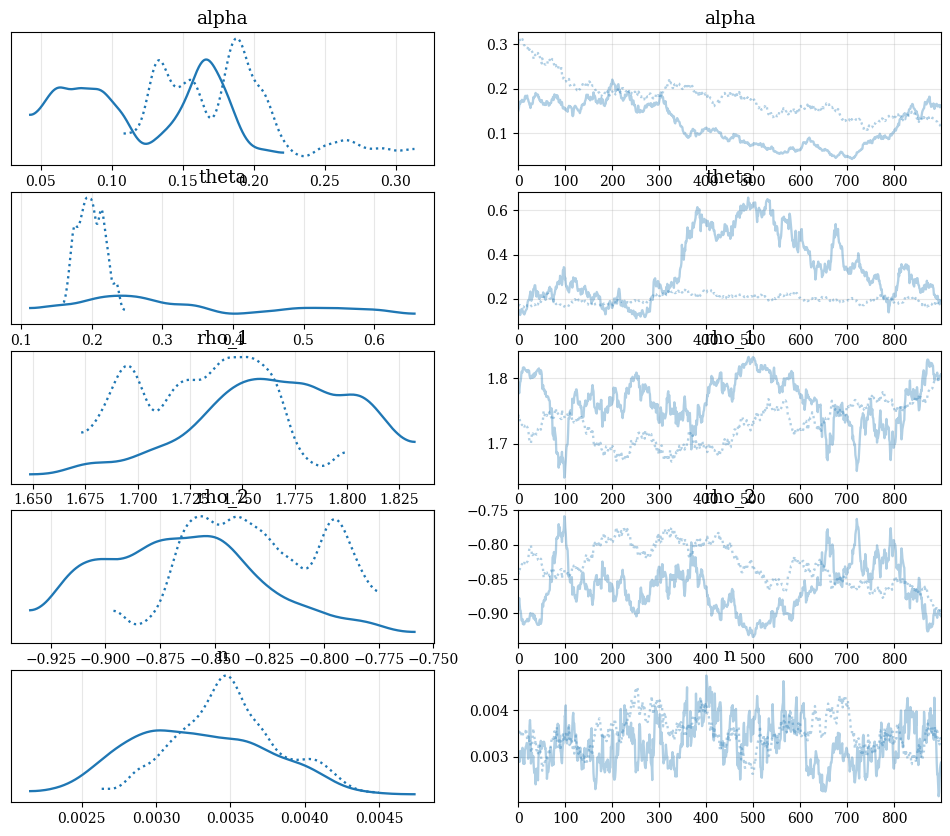

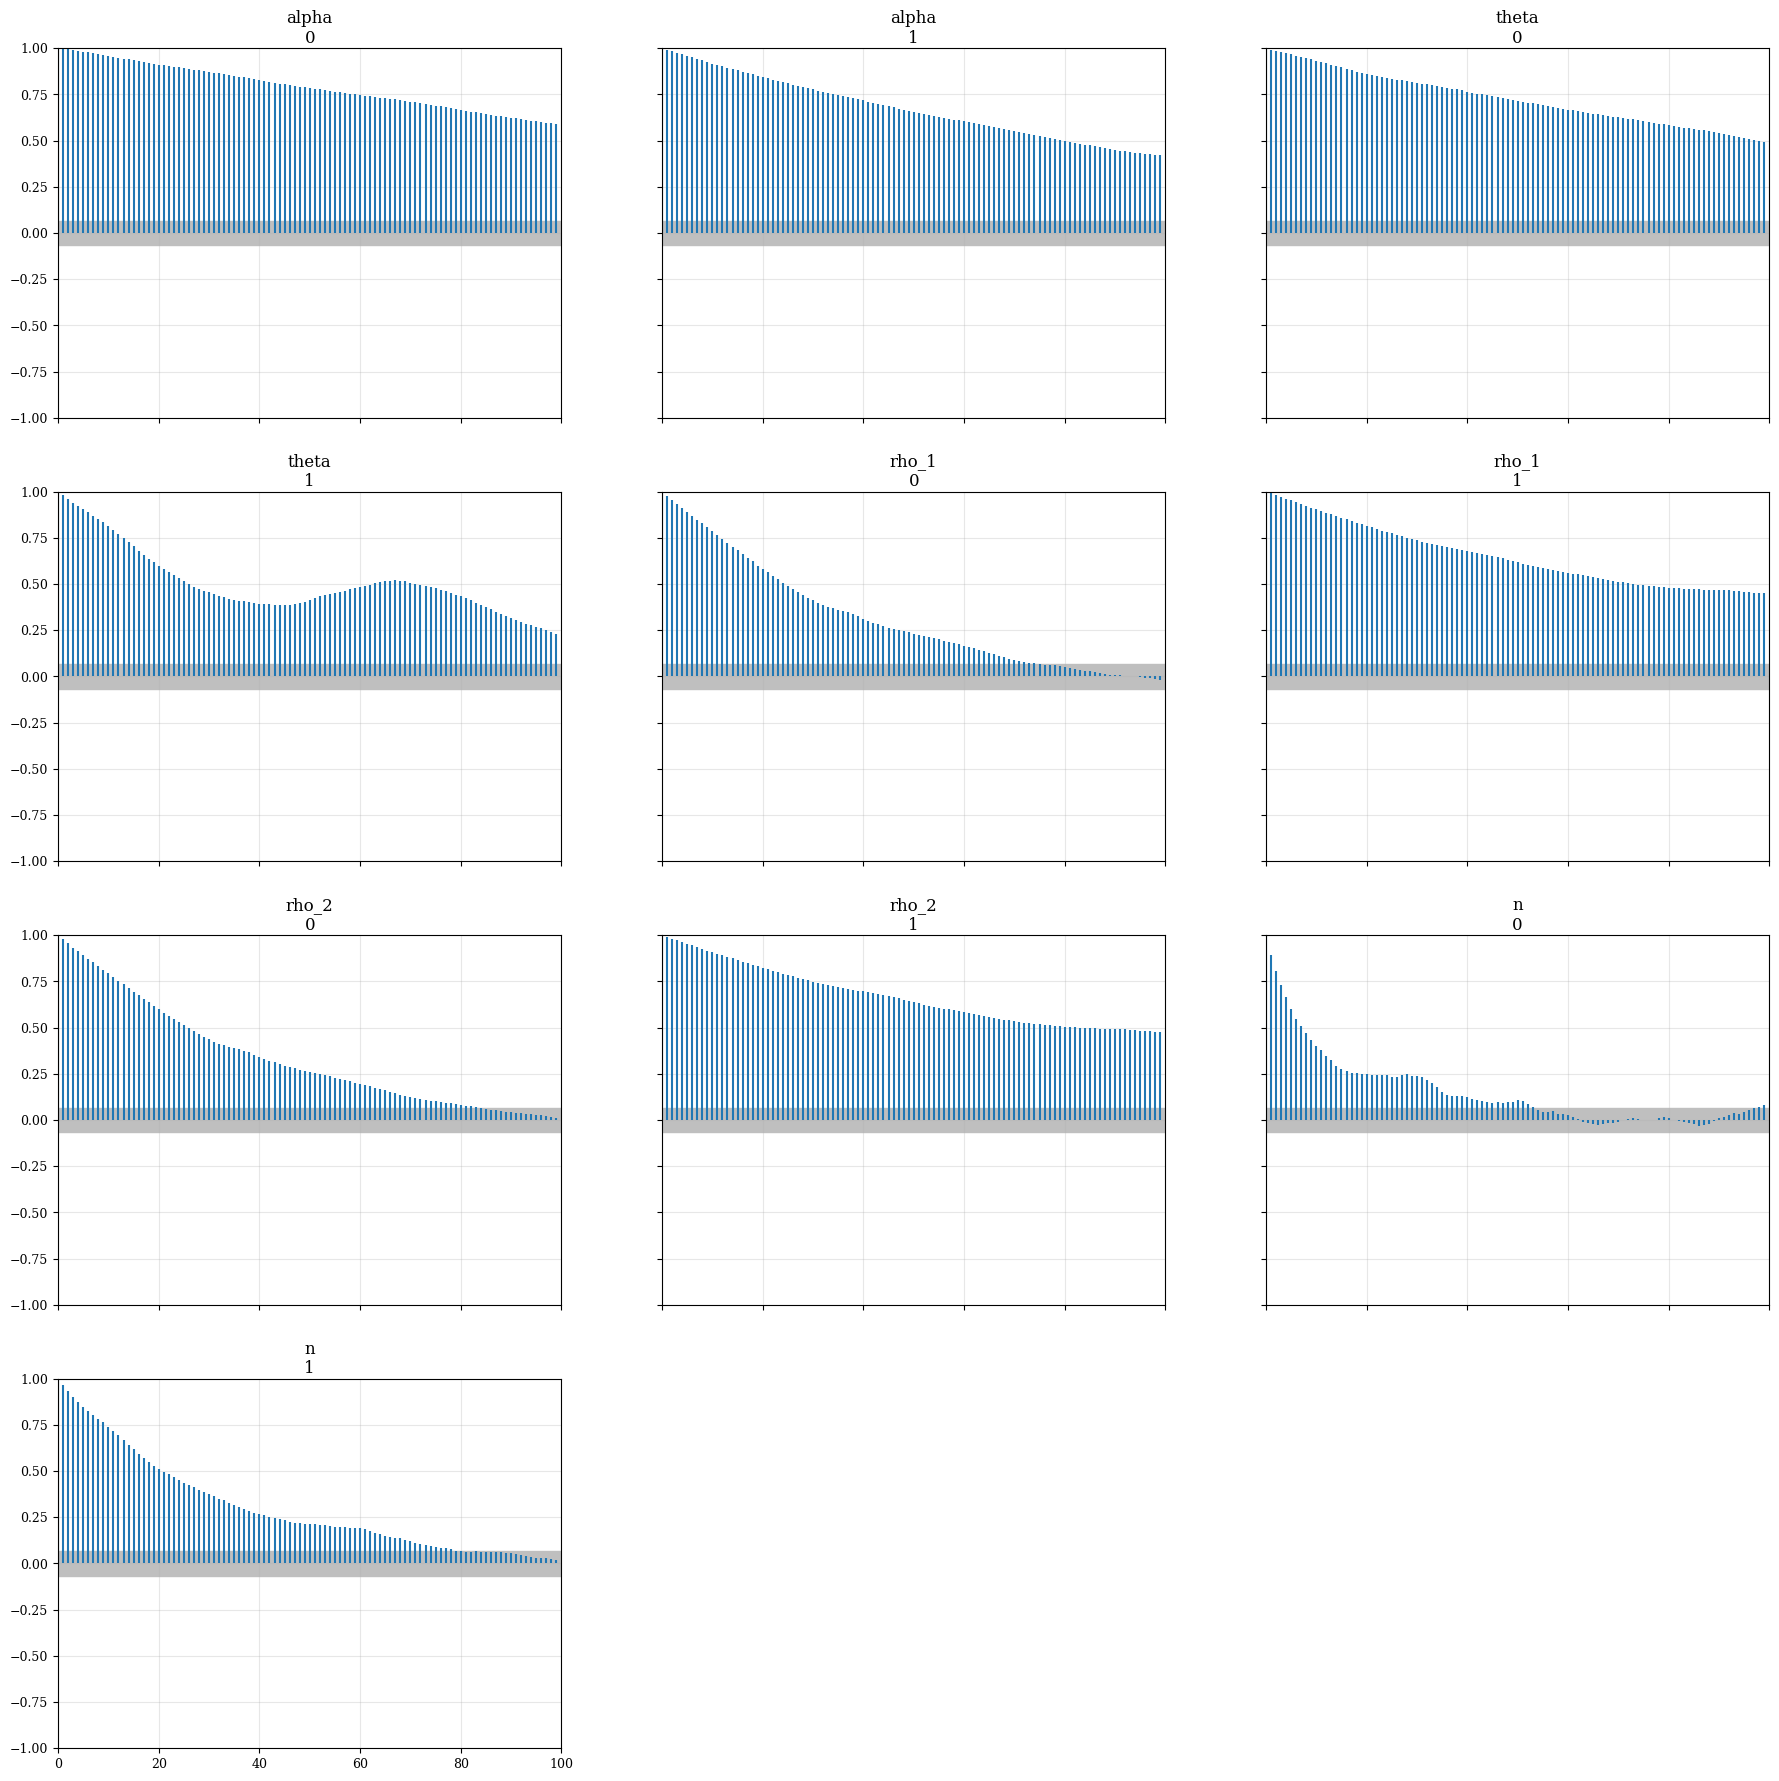

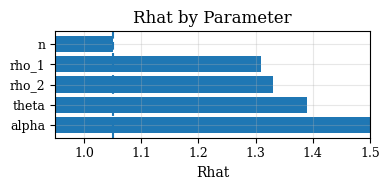

In [ ]:
az.plot_trace(idata, var_names=["alpha", "theta", "rho_1","rho_2",  "n"])
# az.plot_autocorr(idata, var_names=["alpha", "theta", "rho_1","rho_2" ,  "n"])
summary = az.summary(idata,var_names=["alpha","theta", "rho_1","rho_2",  "n"],round_to=2)
rhat = summary['r_hat'].sort_values(ascending=False)
# 3) Plot
plt.figure(figsize=(4, 2))
plt.barh(rhat.index, rhat.values)
plt.axvline(1.05, linestyle='--')        
plt.xlabel('Rhat')                         
plt.title('Rhat by Parameter')             
plt.xlim(0.95, 1.5)
plt.tight_layout()
plt.show()

In [ ]:
def model_3(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    # rho_1 = numpyro.sample("rho_1", dist.Uniform(0,2))
    # rho_2 = numpyro.sample("rho_2", dist.Uniform(-1,0))
    r = numpyro.sample("r", dist.Uniform(-1,1))  # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    delta = numpyro.sample("delta", priors["delta"])
    psi = numpyro.sample("psi", priors["psi"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])         
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))  # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, 0.1))  # Nhat init
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # N 
        m_t = n + Nbar_prev                     
        m_t_pos = jnp.clip(m_t, 1e-8)           
        mu_t = jnp.log(m_t_pos) - 0.5 * sigma_eps**2
        Nbar_t = numpyro.sample("Nbar", dist.LogNormal(mu_t, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # kappa
        kappa_t = numpyro.deterministic("kappa", psi*kappa_prev + delta * (1/Nbar_t))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_prev, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa_0 , t], timesteps)


# model 3
print("NKPC under HSA: shift in slope")
kernel = NUTS(model_3, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, x=x, N=N, l=len(pi))
idata_3_m = az.from_numpyro(mcmc)

# Results
posterior_samples = mcmc.get_samples()
N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_3_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_3_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_3_m = N_bar_mean_3_m - 1.97 * N_bar_std_3_m
N_bar_upper_3_m = N_bar_mean_3_m + 1.97 * N_bar_std_3_m
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_3_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_3_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_3_m = N_hat_mean_3_m - 1.97 * N_hat_std_3_m
N_hat_upper_3_m = N_hat_mean_3_m + 1.97 * N_hat_std_3_m
kappa_samples = posterior_samples["kappa"]
kappa_mean_3_m = np.mean(kappa_samples, axis=0) 
kappa_std_3_m = np.std(kappa_samples, axis=0)  
kappa_lower_3_m = kappa_mean_3_m - 1.97 * kappa_std_3_m
kappa_upper_3_m = kappa_mean_3_m + 1.97 * kappa_std_3_m

diverging  = idata_3_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 3 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'NKPC under HSA: shift':idata_3_m
    }
params = [
    "alpha", "kappa", "theta", "rho_1","rho_2", "delta", "psi" ,  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

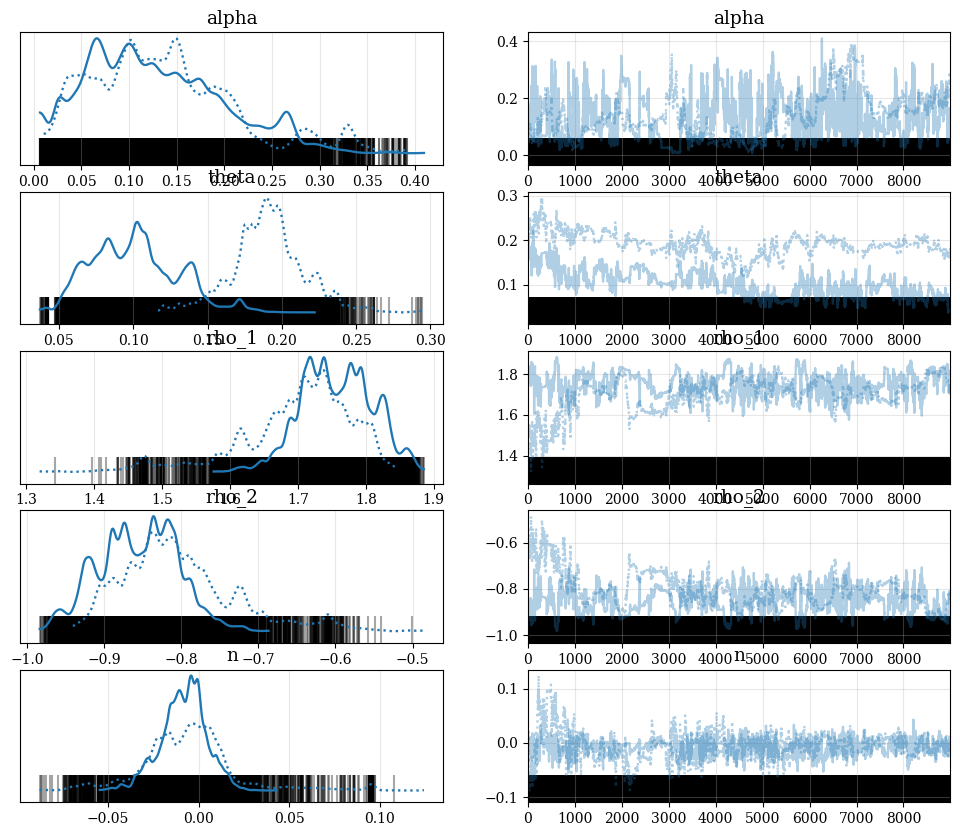

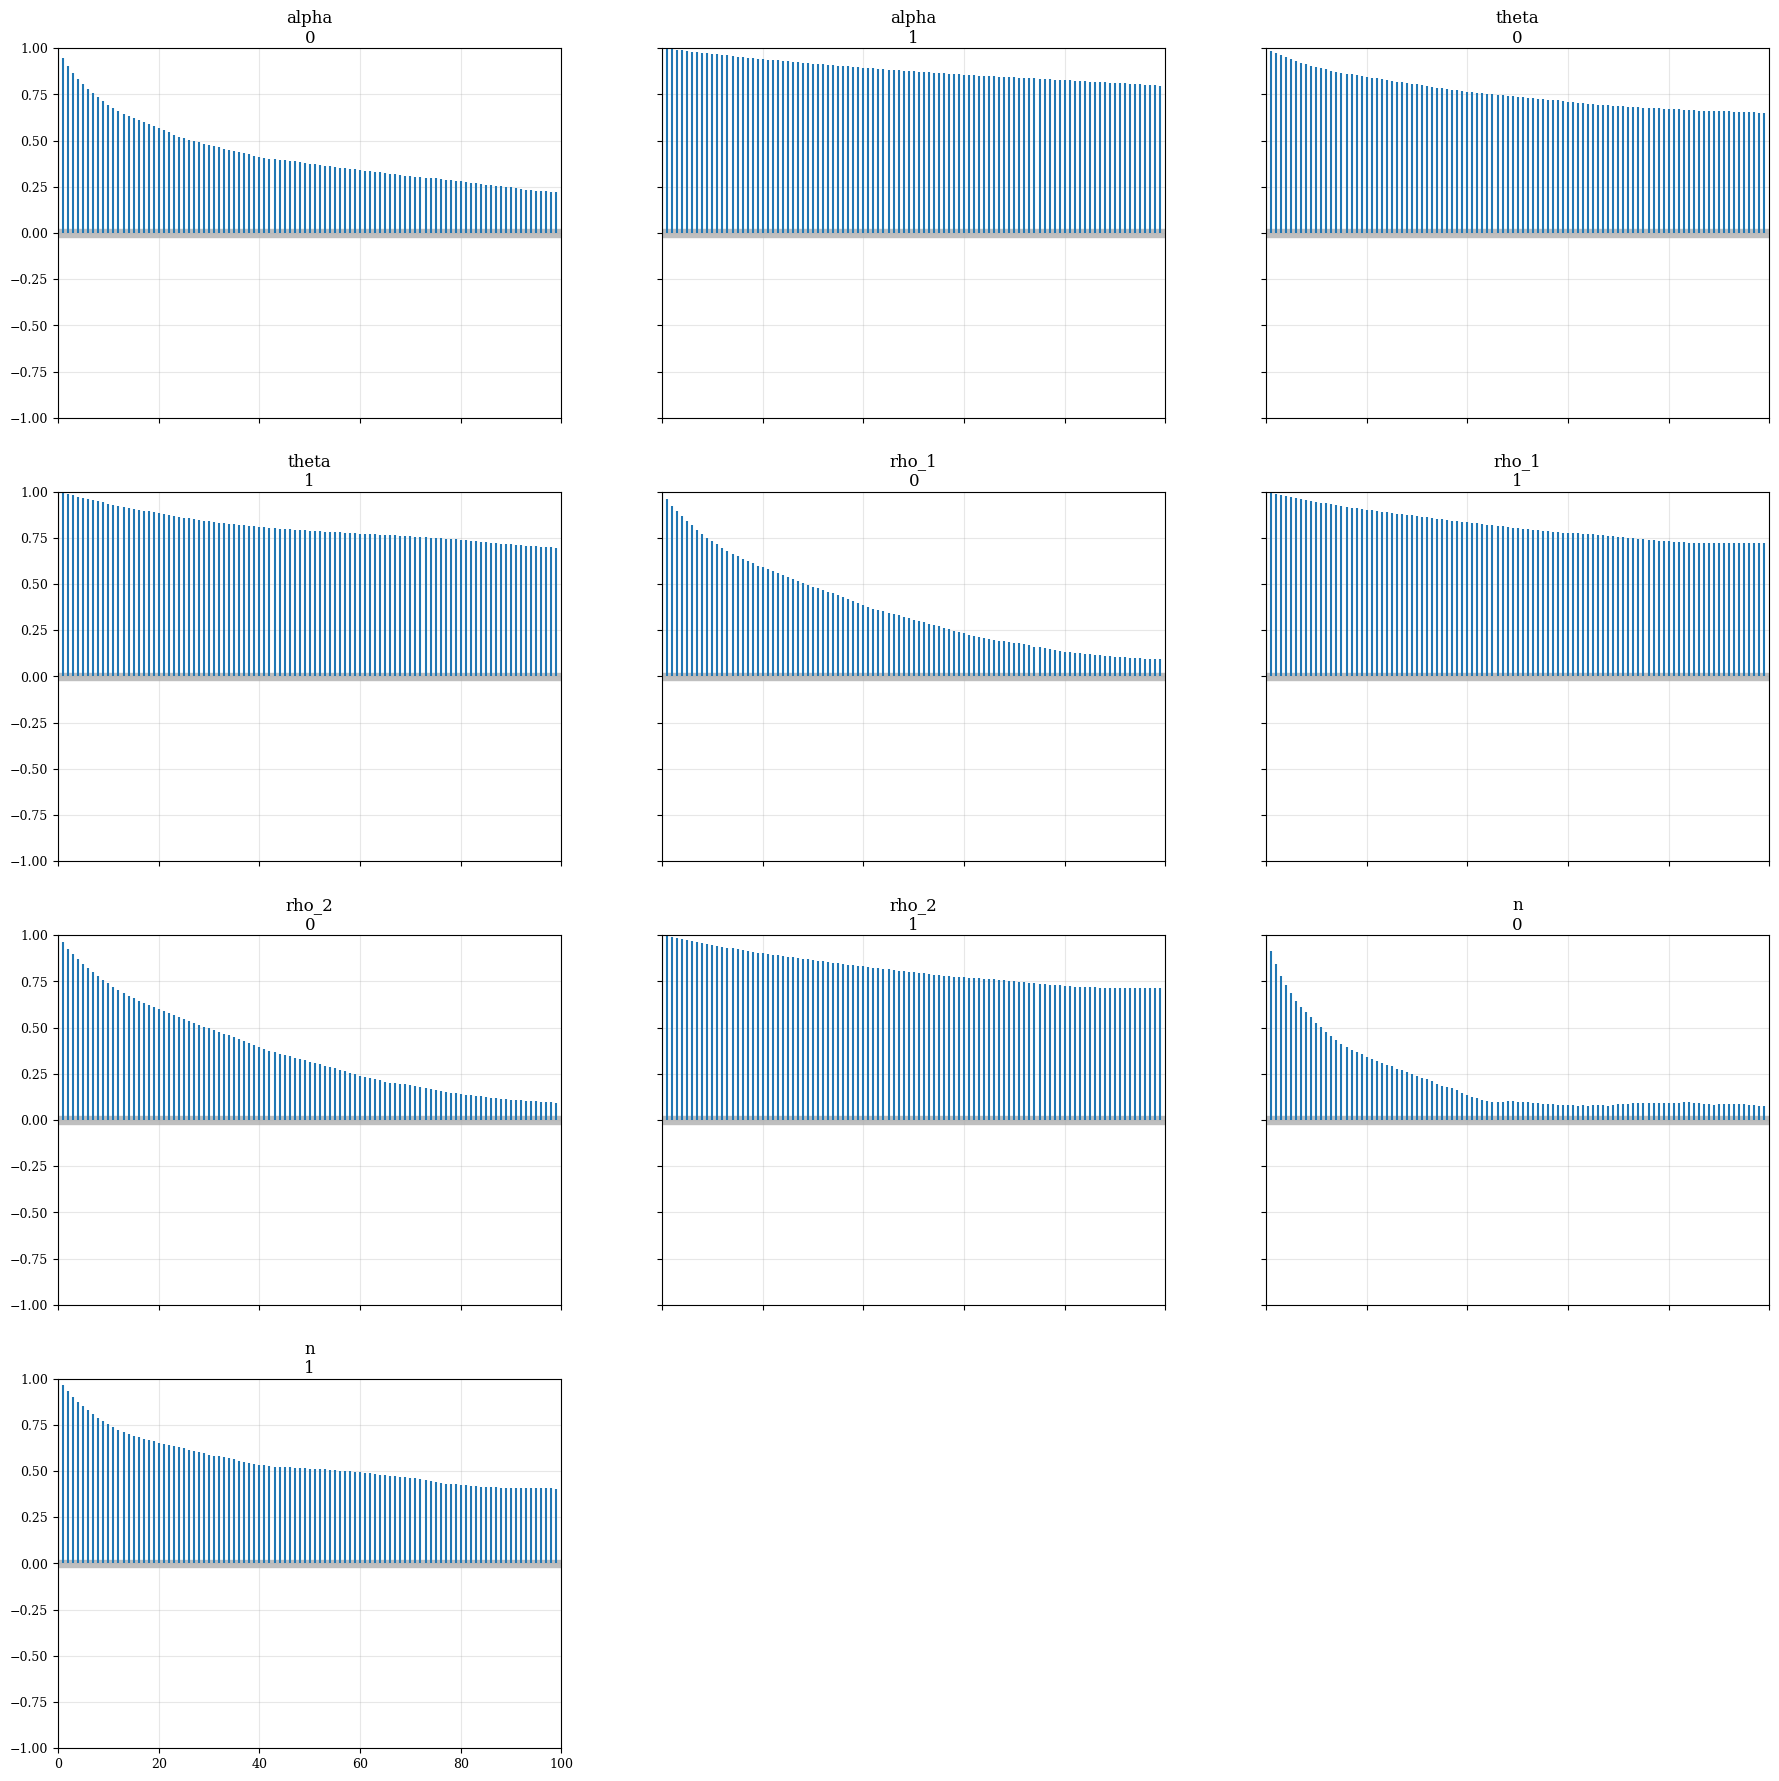

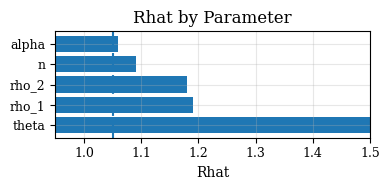

In [ ]:
az.plot_trace(idata, var_names=["alpha", "theta", "rho_1","rho_2",  "n"])
# az.plot_autocorr(idata, var_names=["alpha", "theta", "rho_1","rho_2" ,  "n"])
summary = az.summary(idata,var_names=["alpha","theta", "rho_1","rho_2",  "n"],round_to=2)
rhat = summary['r_hat'].sort_values(ascending=False)
# 3) Plot
plt.figure(figsize=(4, 2))
plt.barh(rhat.index, rhat.values)
plt.axvline(1.05, linestyle='--')        # threshold line
plt.xlabel('Rhat')                         
plt.title('Rhat by Parameter')             
plt.xlim(0.95, 1.5)
plt.tight_layout()
plt.show()

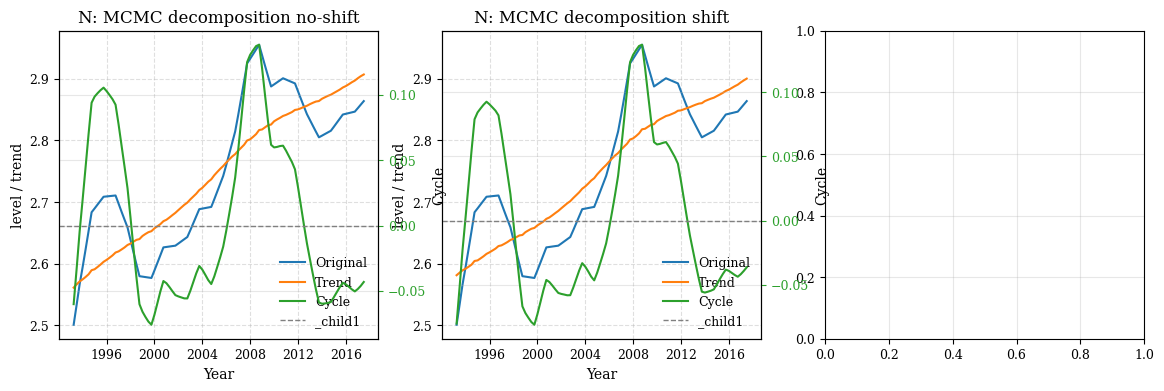

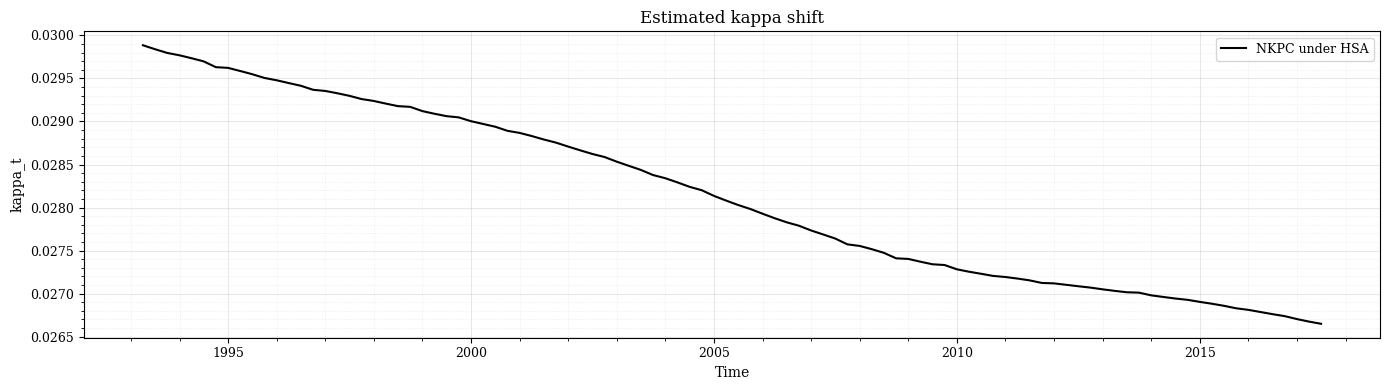

In [ ]:
# --------------------------------------------------------
# Combined Figure for Model Plots
# --------------------------------------------------------
scale = 2
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=False)
# First decomposition: no shift
plot_decomposition_ax(
    axes[0],
    data["DATE"], data["N"], N_bar_mean_1_m, N_hat_mean_1_m,
    "N: MCMC decomposition no-shift", loc="lower right"
)

# Second decomposition: shift
plot_decomposition_ax(
    axes[1],
    data["DATE"], data["N"], N_bar_mean_2_m, N_hat_mean_2_m,
    "N: MCMC decomposition shift", loc="lower right"
)

plot_decomposition_ax(
    axes[1],
    data["DATE"], data["N"], N_bar_mean_3_m, N_hat_mean_3_m,
    "N: MCMC decomposition shift", loc="lower right"
)

scale = 1
fig, axes = plt.subplots(1, 1, figsize=(14, 4), sharex=False)
# Final layout
axes.plot(data["DATE"], kappa_mean_2_m, label="NKPC under HSA", color=colors[0])
axes.set_title("Estimated kappa shift")
axes.set_xlabel("Time")
axes.set_ylabel("kappa_t")
axes.legend()
axes.minorticks_on()
axes.grid(which='major', linestyle='-', linewidth=0.75)
axes.grid(which='minor', linestyle=':', linewidth=0.5)
axes.xaxis.set_major_locator(mdates.YearLocator(5))
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(14, 4), sharex=False)
# Final layout
axes.plot(data["DATE"], kappa_mean_3_m, label="NKPC under HSA", color=colors[0])
axes.set_title("Estimated kappa shift")
axes.set_xlabel("Time")
axes.set_ylabel("kappa_t")
axes.legend()
axes.minorticks_on()
axes.grid(which='major', linestyle='-', linewidth=0.75)
axes.grid(which='minor', linestyle=':', linewidth=0.5)
axes.xaxis.set_major_locator(mdates.YearLocator(5))
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.tight_layout()
plt.show()

## Model Comparison

## WAIC
（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
- log pointwise predictive density
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
This term measures the average fit of the model across all posterior draws. It’s like the average log-likelihood, but averaged over the posterior.
- effective number of parameters
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$
This captures how much the log-likelihood varies across posterior samples for each data point. High variance means the model is more complex (more sensitive to the choice of parameters), so it penalizes complexity.

## Leave-One-Out (LOO) cross-validation
The LOO expected log predictive density is defined as
$$
\operatorname{elpd}_{\text{loo}}
\;=\;
\sum_{i=1}^{n}
  \log p\!\bigl(y_i \,\mid\, y_{-i}\bigr).
$$

where
$$
p\!\bigl(y_i \mid y_{-i}\bigr)
\;=\;
\int
  p\!\bigl(y_i \mid \boldsymbol{\theta}\bigr)\,
  p\!\bigl(\boldsymbol{\theta} \mid y_{-i}\bigr)\,
d\boldsymbol{\theta}
$$

**Interpretation** : 

$\operatorname{elpd}_{\text{loo}}$ sums the log predictive density for each observation when that observation is left out of the estimation.  Higher values indicate better out-of-sample predictive accuracy.

**Efficient computation**:

In practice we approximate (4)–(5) using \emph{PSIS-LOO} (Pareto-smoothed importance sampling), which avoids refitting the model $n$ times.

**Complexity penalty**: 
An effective number of parameters can be defined analogously to WAIC as
  $$
    p_{\text{LOO}} \;=\; \sum_{i=1}^{n} \operatorname{Var}_{\theta}
      \!\bigl(\log p(y_i \mid \boldsymbol{\theta})\bigr),
  $$
  so that $\text{LOOIC} = -2\,(\operatorname{elpd}_{\text{loo}} - p_{\text{LOO}})$.

,model,alpha,kappa,theta,rho_1,rho_2,n,delta,psi
0,NKPC: CES,0.153,0.079,-,-,-,-,-,-
1,NKPC: HSA no-shift,0.157,0.079,0.268,1.793,-0.891,0.003,-,-
2,NKPC: HSA shift,0.133,-,0.146,1.728,-0.829,-0.007,0.008,-


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

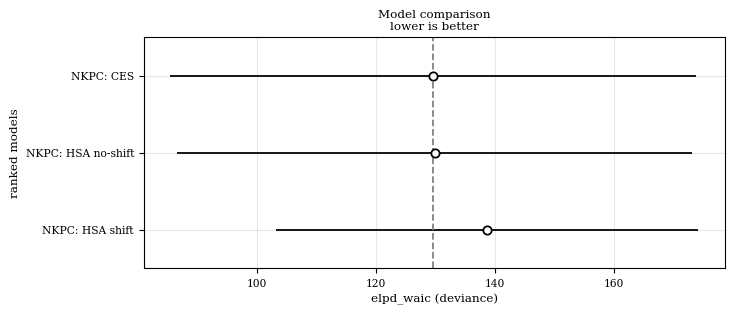

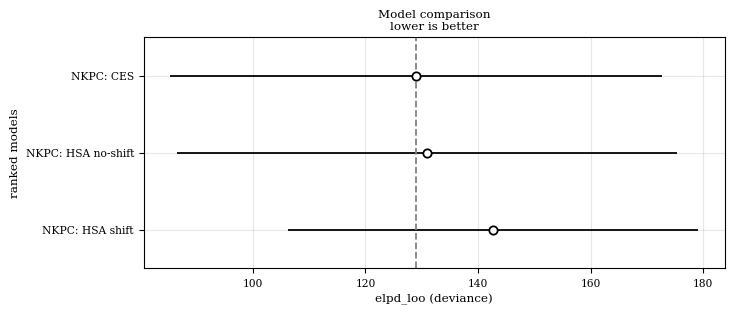

In [ ]:
dict_idata = {
    'NKPC: CES':idata_0_m, 'NKPC: HSA no-shift':idata_1_m, 'NKPC: HSA shift':idata_2_m, 'NKPC: HSA shift/kappa prev':idata_3_m, 
    }

params = [
    "alpha", "kappa", "theta", "rho_1", "rho_2",  "n", "delta", "psi",
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
df_loo = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')
scale = 3  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))
az.plot_compare(df_loo, figsize=(2.5*scale, 1*scale))

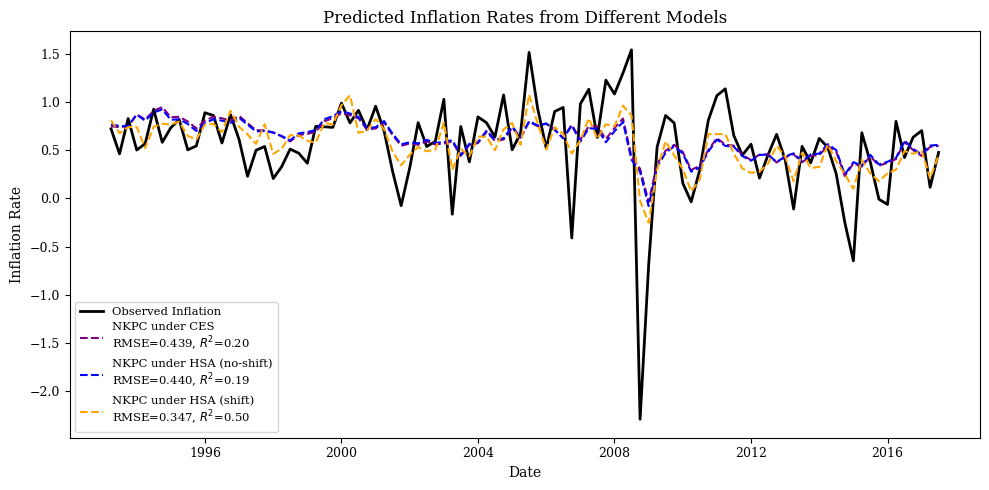

In [ ]:
pi_prd_0  = idata_0_m.posterior["alpha"].mean().item() * pi_prev + (1 - idata_0_m.posterior["alpha"].mean().item()) * pi_expect + idata_0_m.posterior["kappa"].mean().item() * x_markup
pi_pred_1 = idata_1_m.posterior["alpha"].mean().item() * pi_prev + (1 - idata_1_m.posterior["alpha"].mean().item()) * pi_expect + idata_1_m.posterior["kappa"].mean().item() * x_markup - idata_1_m.posterior["theta"].mean().item() * N_hat_mean_1_m
pi_pred_2 = idata_2_m.posterior["alpha"].mean().item() * pi_prev + (1 - idata_2_m.posterior["alpha"].mean().item()) * pi_expect + kappa_mean_2_m * x_markup - idata_2_m.posterior["theta"].mean().item() * N_hat_mean_2_m
pi_pred_3 = idata_3_m.posterior["alpha"].mean().item() * pi_prev + (1 - idata_3_m.posterior["alpha"].mean().item()) * pi_expect + kappa_mean_3_m * x_markup - idata_3_m.posterior["theta"].mean().item() * N_hat_mean_3_m

# --- after you compute pi_pred_1…pi_pred_4 ---
def rmse(pred, obs):
    return np.sqrt(np.mean((pred - obs)**2))

def r2(pred, obs):
    ss_res = np.sum((obs - pred)**2)
    ss_tot = np.sum((obs - np.mean(obs))**2)
    return 1 - ss_res/ss_tot

# compute metrics
rmse0, r20 = rmse(pi_prd_0, pi), r2(pi_prd_0, pi)
rmse1, r21 = rmse(pi_pred_1, pi), r2(pi_pred_1, pi)
rmse2, r22 = rmse(pi_pred_2, pi), r2(pi_pred_2, pi)

# Plotting the predicted inflation rates
plt.figure(figsize=(10, 5))
plt.plot(data["DATE"], pi, label="Observed Inflation", color='black', linewidth=2)
plt.plot(
    data["DATE"], pi_prd_0,
    label=f"NKPC under CES \nRMSE={rmse0:.3f}, $R^2$={r20:.2f}",
    color='purple', linestyle='--'
)
plt.plot(
    data["DATE"], pi_pred_1,
    label=f"NKPC under HSA (no-shift)\nRMSE={rmse1:.3f}, $R^2$={r21:.2f}",
    color='blue', linestyle='--'
)
plt.plot(
    data["DATE"], pi_pred_2,
    label=f"NKPC under HSA (shift)\nRMSE={rmse2:.3f}, $R^2$={r22:.2f}",
    color='orange', linestyle='--'
)
plt.plot(
    data["DATE"], pi_pred_3,
    label=f"NKPC under HSA (shift) kappa_prev \nRMSE={rmse2:.3f}, $R^2$={r22:.2f}",
    color='orange', linestyle='--'
)
plt.title("Predicted Inflation Rates from Different Models")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.legend(loc="lower left", fontsize='small', framealpha=0.8)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
x = x_markup
x_prev = x_markup_prev
# NKPC under CES =================================================
print("NKPC under CES")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x)
idata_0_m = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
diverging  = idata_0_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param
# NKPC under HSA : no shift in slope ==============================
print("NKPC under HSA : no shift in slope")
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x, N = N, l=len(pi))
idata_1_m = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_1_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_1_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_1_m = N_bar_mean_1_m - 1.97 * N_bar_std_1_m
N_bar_upper_1_m = N_bar_mean_1_m + 1.97 * N_bar_std_1_m
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_1_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_1_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_1_m = N_hat_mean_1_m - 1.97 * N_hat_std_1_m
N_hat_upper_1_m = N_hat_mean_1_m + 1.97 * N_hat_std_1_m
diverging  = idata_1_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")
# ====================================================================
# model 2
print("NKPC under HSA: shift in slope")
kernel = NUTS(model_2, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, x=x, N=N, l=len(pi))
idata_2_m = az.from_numpyro(mcmc)

# Results
posterior_samples = mcmc.get_samples()
N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_2_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_2_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_2_m = N_bar_mean_2_m - 1.97 * N_bar_std_2_m
N_bar_upper_2_m = N_bar_mean_2_m + 1.97 * N_bar_std_2_m
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_2_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_2_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_2_m = N_hat_mean_2_m - 1.97 * N_hat_std_2_m
N_hat_upper_2_m = N_hat_mean_2_m + 1.97 * N_hat_std_2_m
kappa_samples = posterior_samples["kappa"]
kappa_mean_2_m = np.mean(kappa_samples, axis=0) 
kappa_std_2_m = np.std(kappa_samples, axis=0)  
kappa_lower_2_m = kappa_mean_2_m - 1.97 * kappa_std_2_m
kappa_upper_2_m = kappa_mean_2_m + 1.97 * kappa_std_2_m

diverging  = idata_2_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")


# model 3
print("NKPC under HSA: shift in slope")
kernel = NUTS(model_3, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, x=x, N=N, l=len(pi))
idata_3_m = az.from_numpyro(mcmc)

# Results
posterior_samples = mcmc.get_samples()
N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_3_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_3_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_3_m = N_bar_mean_3_m - 1.97 * N_bar_std_3_m
N_bar_upper_3_m = N_bar_mean_3_m + 1.97 * N_bar_std_3_m
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_3_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_3_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_3_m = N_hat_mean_3_m - 1.97 * N_hat_std_3_m
N_hat_upper_3_m = N_hat_mean_3_m + 1.97 * N_hat_std_3_m
kappa_samples = posterior_samples["kappa"]
kappa_mean_3_m = np.mean(kappa_samples, axis=0) 
kappa_std_3_m = np.std(kappa_samples, axis=0)  
kappa_lower_3_m = kappa_mean_3_m - 1.97 * kappa_std_3_m
kappa_upper_3_m = kappa_mean_3_m + 1.97 * kappa_std_3_m

diverging  = idata_3_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 3 : divergence ratio = {ratio_div:.4%}")


dict_idata = {
    'NKPC under CES':idata_0_m,
    'HSA NKPC no-shift':idata_1_m,
    'HSA NKPC shift': idata_2_m,
    'HSA NKPC shift with kappa_prev': idata_3_m,
    }
params = [
    "alpha", "kappa", "theta", "rho_1","rho_2", "psi", 'delta',  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

NKPC under CES


sample: 100%|██████████| 10000/10000 [00:04<00:00, 2365.79it/s, 15 steps of size 1.94e-01. acc. prob=0.99]


model 0: divergence ratio = 0.0000%
NKPC under HSA : no shift in slope


warmup:   1%|          | 66/10000 [00:07<18:15,  9.07it/s, 1023 steps of size 2.02e-04. acc. prob=0.87]


KeyboardInterrupt: 

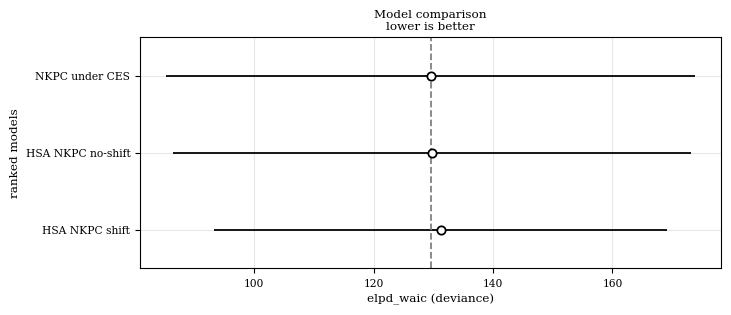

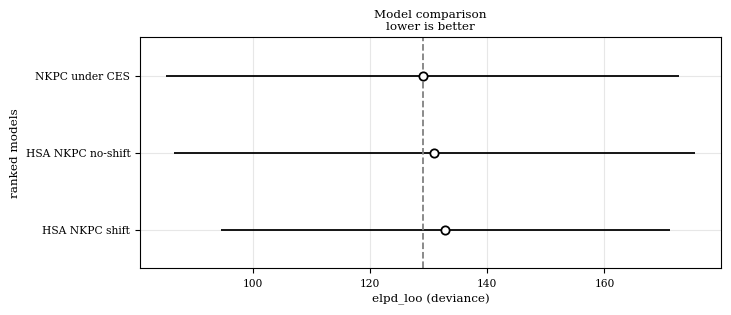

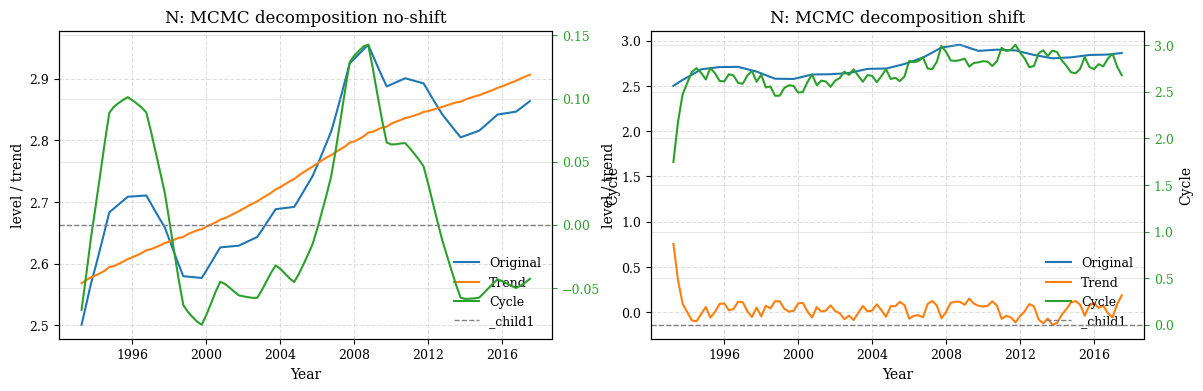

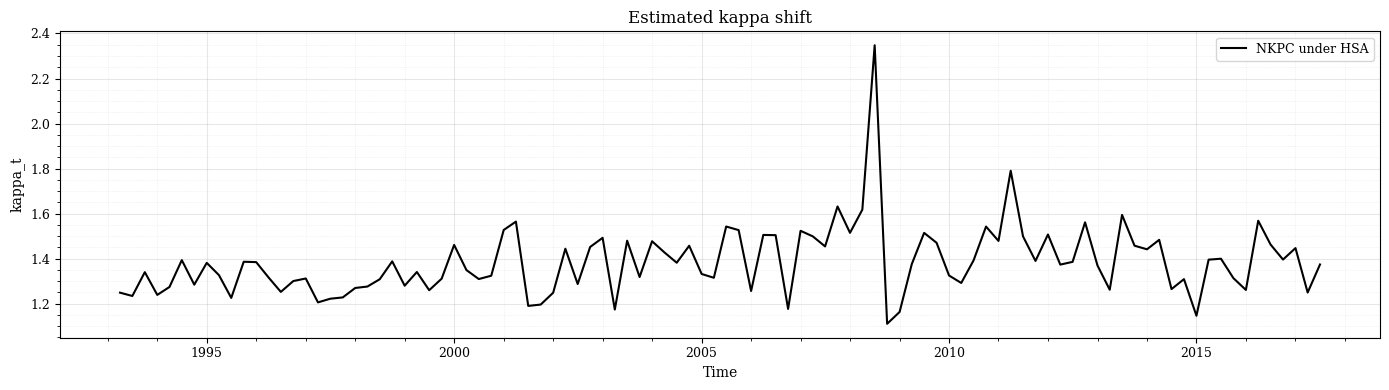

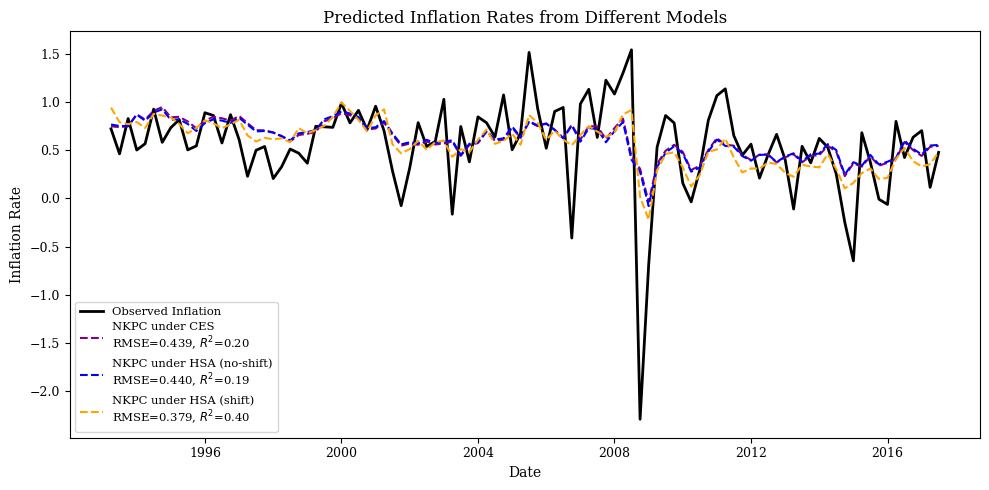

In [ ]:

df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
df_loo = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')
scale = 3  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))
az.plot_compare(df_loo, figsize=(2.5*scale, 1*scale))
# --------------------------------------------------------
# Combined Figure for Model Plots
# --------------------------------------------------------
scale = 2
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=False)
# First decomposition: no shift
plot_decomposition_ax(
    axes[0],
    data["DATE"], data["N"], N_bar_mean_1_m, N_hat_mean_1_m,
    "N: MCMC decomposition no-shift", loc="lower right"
)

# Second decomposition: shift
plot_decomposition_ax(
    axes[1],
    data["DATE"], data["N"], N_bar_mean_2_m, N_hat_mean_2_m,
    "N: MCMC decomposition shift", loc="lower right"
)

scale = 1
fig, axes = plt.subplots(1, 1, figsize=(14, 4), sharex=False)
# Final layout
axes.plot(data["DATE"], kappa_mean_2_m, label="NKPC under HSA", color=colors[0])
axes.set_title("Estimated kappa shift")
axes.set_xlabel("Time")
axes.set_ylabel("kappa_t")
axes.legend()
axes.minorticks_on()
axes.grid(which='major', linestyle='-', linewidth=0.75)
axes.grid(which='minor', linestyle=':', linewidth=0.5)
axes.xaxis.set_major_locator(mdates.YearLocator(5))
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.tight_layout()
plt.show()

pi_prd_0  = idata_0_m.posterior["alpha"].mean().item() * pi_prev + (1 - idata_0_m.posterior["alpha"].mean().item()) * pi_expect + idata_0_m.posterior["kappa"].mean().item() * x
pi_pred_1 = idata_1_m.posterior["alpha"].mean().item() * pi_prev + (1 - idata_1_m.posterior["alpha"].mean().item()) * pi_expect + idata_1_m.posterior["kappa"].mean().item() * x - idata_1_m.posterior["theta"].mean().item() * N_hat_mean_1_m
pi_pred_2 = idata_2_m.posterior["alpha"].mean().item() * pi_prev + (1 - idata_2_m.posterior["alpha"].mean().item()) * pi_expect + kappa_mean_2_m * x - idata_2_m.posterior["theta"].mean().item() * N_hat_mean_2_m
pi_pred_3 = idata_3_m.posterior["alpha"].mean().item() * pi_prev + (1 - idata_3_m.posterior["alpha"].mean().item()) * kappa_mean_3_m * x - idata_3_m.posterior["theta"].mean().item() * N_hat_mean_3_m
# --- after you compute pi_pred_1…pi_pred_4 ---
def rmse(pred, obs):
    return np.sqrt(np.mean((pred - obs)**2))

def r2(pred, obs):
    ss_res = np.sum((obs - pred)**2)
    ss_tot = np.sum((obs - np.mean(obs))**2)
    return 1 - ss_res/ss_tot

# compute metrics
rmse0, r20 = rmse(pi_prd_0, pi), r2(pi_prd_0, pi)
rmse1, r21 = rmse(pi_pred_1, pi), r2(pi_pred_1, pi)
rmse2, r22 = rmse(pi_pred_2, pi), r2(pi_pred_2, pi)
rmse3, r23 = rmse(pi_pred_3, pi), r2(pi_pred_3, pi)

# Plotting the predicted inflation rates
plt.figure(figsize=(10, 5))
plt.plot(data["DATE"], pi, label="Observed Inflation", color='black', linewidth=2)
plt.plot(
    data["DATE"], pi_prd_0,
    label=f"NKPC under CES \nRMSE={rmse0:.3f}, $R^2$={r20:.2f}",
    color='purple', linestyle='--'
)

plt.plot(
    data["DATE"], pi_pred_1,
    label=f"NKPC under HSA (no-shift)\nRMSE={rmse1:.3f}, $R^2$={r21:.2f}",
    color='blue', linestyle='--'
)
plt.plot(
    data["DATE"], pi_pred_2,
    label=f"NKPC under HSA (shift)\nRMSE={rmse2:.3f}, $R^2$={r22:.2f}",
    color='orange', linestyle='--'
)
plt.plot(
    data["DATE"], pi_pred_3,
    label=f"NKPC under HSA (shift, kappa prev)\nRMSE={rmse3:.3f}, $R^2$={r23:.2f}",
    color='green', linestyle='--'
)
plt.title("Predicted Inflation Rates from Different Models")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.legend(loc="lower left", fontsize='small', framealpha=0.8)
plt.grid()
plt.tight_layout()
plt.show()